In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
data = pd.read_excel('Индивидуальное задание ВКВФ.xlsx', sheet_name='Маршрут 4', skiprows=1)
data = data.iloc[:, :2]
data = data.rename({data.columns[0]: 'lambda', data.columns[1]: 'EQE'}, axis=1)
am0 = pd.read_excel('Индивидуальное задание ВКВФ.xlsx', sheet_name='АМ0', skiprows=1)
am0 = am0.iloc[:, :2]
am0 = am0.rename({am0.columns[0]: 'lambda', am0.columns[1]: 'E'}, axis=1)
I0 = 8.71710580602887e-17 # mA/cm2
S = 4 # cm2

In [3]:
(am0['lambda'].diff() * am0['E']).sum()

1359.7927

In [4]:
am0 = am0[(am0['lambda'] >= data['lambda'].min()) & (am0['lambda'] <= data['lambda'].max())]

In [5]:
forest = RandomForestRegressor(n_estimators=1000)
X = data['lambda'].values.reshape(-1, 1)
y = data['EQE'].values
forest.fit(X, y)

RandomForestRegressor(n_estimators=1000)

In [6]:
MAE = mean_absolute_error(y, forest.predict(X))
print(MAE)

0.009453549111111046


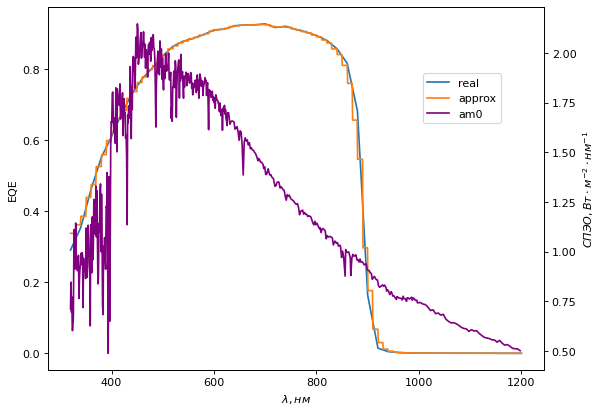

In [7]:
fig, ax1 = plt.subplots(figsize=(8, 6), dpi=80)
ax2 = ax1.twinx()

ax1.plot(data['lambda'], data['EQE'], label='real')
ax1.set_ylabel('EQE')
ax1.set_xlabel('$\lambda, нм$')
ax1.plot(np.linspace(X.min(), X.max(), 1000), forest.predict(np.linspace(X.min(), X.max(), 1000).reshape(-1, 1)), label='approx')
ax2.plot(am0['lambda'], am0['E'], c='purple', label='am0')
ax2.set_ylabel('$СПЭО, Вт\cdotм^{-2}\cdotнм^{-1}$')
handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
fig.legend(handles, labels, loc=(0.7, 0.7));

In [8]:
am0['EQE'] = forest.predict(am0['lambda'].values.reshape(-1, 1))
am0['lambda/h'] = am0['lambda'] / (4.135e-15 * 3e8 * 1e9)

In [9]:
am0['Jkz'] = (am0['lambda'].diff() * am0['EQE'] * am0['E'] / 10000 * am0['lambda/h']).fillna(0)
am0['Jkz_cumsum'] = am0['Jkz'].cumsum()

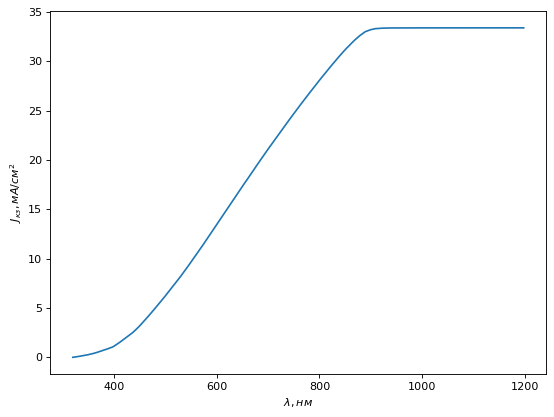

In [10]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(am0['lambda'], am0['Jkz_cumsum'] * 1000)
plt.ylabel('$J_{кз}, мА/см^{2}$')
plt.xlabel('$\lambda, нм$');

In [11]:
I_kz_final = am0['Jkz_cumsum'].values[-1] * S
I_0 = I0 * S

In [12]:
X = np.linspace(start=-0.5, stop=0.9, num=1000)
count_I = lambda x: - I_kz_final + I_0 * (np.exp(x/0.026) - 1)
y = np.vectorize(count_I)
y = y(X)

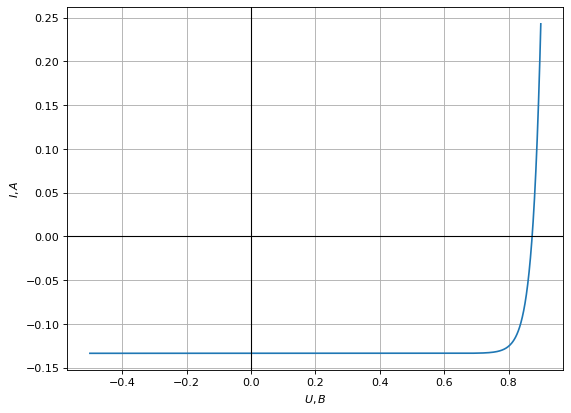

In [13]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(X, y)
plt.ylabel('$I, A$')
plt.xlabel('$U, В$')
plt.axvline(0, c='black', linewidth=1)
plt.axhline(0, c='black', linewidth=1)
plt.grid();